In [3]:
%matplotlib inline
#load packages and data
import datetime
import holidays
import re #regular expressions
import MySQLdb
import pandas.io.sql as sql
import pandas as pd
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn import cross_validation, preprocessing, linear_model, neighbors, feature_extraction, grid_search, pipeline, metrics, ensemble
import dill

In [4]:
#get current twitter data from db
conn = MySQLdb.connect(host="localhost", port=3306, user="root", db="disney_db") #make db connection
cursor = conn.cursor()
cursor.execute("SELECT id, user, timestamp, search, location FROM twitter_data_copy WHERE location = 'anaheim'")
rows = cursor.fetchall()
tweetdf = pd.DataFrame( [[ij for ij in i] for i in rows] )
tweetdf.rename(columns={0: 'tweetid', 1: 'user', 2: 'timestamps', 3: 'search', 4: 'location'}, inplace=True)
tweetdf.search = tweetdf.search.apply(lambda x: x.title())
print tweetdf.head()

   tweetid              user          timestamps      search location
0       51  @catcherintherei 2015-08-01 16:55:00  Disneyland  anaheim
1       52      @LambdaPanda 2015-08-01 16:53:00  Disneyland  anaheim
2       53        @rubyray92 2015-08-01 16:46:00  Disneyland  anaheim
3       54         @LovezDee 2015-08-01 16:46:00  Disneyland  anaheim
4       55    @TheEricGraham 2015-08-01 16:34:00  Disneyland  anaheim


In [5]:
#now bin tweets by day
tweetdf['hour'] = [dt.hour for dt in tweetdf.timestamps]
tweetdftrim = tweetdf[tweetdf.hour >= 8]
tweetdftrim = tweetdftrim[tweetdftrim.hour <= 22]

In [6]:
tweetdftrim['day'] = [datetime.datetime(dt.year, dt.month, dt.day) for dt in tweetdftrim.timestamps]
tweets_per_day = pd.DataFrame(tweetdftrim.groupby(['search','day'])['user'].count()).reset_index()
tweets_per_day.head()

,search,day,user
0,California Adventure,2014-12-31,27
1,California Adventure,2015-01-01,55
2,California Adventure,2015-01-02,63
3,California Adventure,2015-01-03,38
4,California Adventure,2015-01-04,50


In [18]:
#import weather data
cursor.execute("SELECT TemperatureF, Wind_SpeedMPH, PrecipitationIN, Conditions, Humidity, DateUTC FROM anaheim_weather WHERE DateUTC > '2014-12-30'")
wrows = cursor.fetchall()
weatherdf = pd.DataFrame( [[ij for ij in i] for i in wrows] )
weatherdf.rename(columns={0: 'temp', 1:'wind', 2:'precip', 3:'conditions', 4:'humidity', 5: 'datetimeUTC'}, inplace=True)
weatherdf.head()

,temp,wind,precip,conditions,humidity,datetimeUTC
0,57.9,6.9,N/A,Clear,65,2014-12-30 00:53:00
1,57.0,0.0,N/A,Clear,69,2014-12-30 01:53:00
2,54.0,0.0,N/A,Clear,75,2014-12-30 02:53:00
3,51.1,0.0,N/A,Clear,80,2014-12-30 03:53:00
4,50.0,0.0,N/A,Clear,80,2014-12-30 04:53:00


In [19]:
weatherdf['datetimeUTC'] =  pd.to_datetime(weatherdf['datetimeUTC'], format='%Y-%m-%d %H:%M:%S.')
weatherdf['timestamp'] = weatherdf['datetimeUTC'] - datetime.timedelta(hours=8)
weatherdf['day'] = [datetime.datetime(dt.year, dt.month, dt.day) for dt in weatherdf.timestamp]
weatherdf.wind.replace(-9999.0, float('NaN'), inplace=True)
weatherdf.temp.replace(-9999.0, float('NaN'), inplace=True)
weatherdf.precip.replace(-9999.0, float('NaN'), inplace=True)
weatherdf.humidity.replace(-9999.0, float('NaN'), inplace=True)
weatherdf.precip.replace('N/A', 0, inplace=True)
weatherdf.humidity.replace('N/A', float('NaN'), inplace=True)
weatherdf['precip'] = pd.to_numeric(weatherdf['precip'])
weatherdf['humidity'] = pd.to_numeric(weatherdf['humidity'])
weatherdf['lotemp'] = weatherdf['temp']
weatherdf = weatherdf.dropna()

In [20]:
daily_weather = pd.DataFrame(weatherdf.groupby(['day']).agg({'temp':np.max, 'lotemp':np.min, 'wind':np.nanmean, 'humidity':np.nanmean, 'precip':np.sum, 'conditions':scipy.stats.mode})).reset_index()
daily_weather.head()

,day,temp,humidity,precip,conditions,wind,lotemp
0,2014-12-29,57.9,78.800000,0.00,"([Clear], [5])",1.960000,48.0
1,2014-12-30,57.9,64.750000,0.12,"([Overcast], [18])",8.192857,46.9
2,2014-12-31,57.0,36.750000,0.00,"([Clear], [19])",3.950000,39.9
3,2015-01-01,59.0,54.250000,0.00,"([Clear], [23])",3.520833,36.0
4,2015-01-02,61.0,67.166667,0.00,"([Clear], [24])",2.266667,37.0


In [21]:
#join weather and twitter data
tweetwaits = pd.merge(tweets_per_day, daily_weather, on='day')
tweetwaits.head()

,search,day,user,temp,humidity,precip,conditions,wind,lotemp
0,California Adventure,2014-12-31,27,57.0,36.750000,0.0,"([Clear], [19])",3.950000,39.9
1,Disneyland,2014-12-31,136,57.0,36.750000,0.0,"([Clear], [19])",3.950000,39.9
2,California Adventure,2015-01-01,55,59.0,54.250000,0.0,"([Clear], [23])",3.520833,36.0
3,Disneyland,2015-01-01,289,59.0,54.250000,0.0,"([Clear], [23])",3.520833,36.0
4,California Adventure,2015-01-02,63,61.0,67.166667,0.0,"([Clear], [24])",2.266667,37.0


In [22]:
#close SQL connection
conn.close()

In [59]:
#get business days and holidays
tweetwaits['business_day'] = [dt.weekday() >= 5 for dt in tweetwaits.day]
us_holidays = holidays.UnitedStates()
tweetwaits['holiday'] = [day in us_holidays for day in tweetwaits.day]
result = tweetwaits.dropna()
result.head()

,search,day,user,temp,humidity,precip,conditions,wind,lotemp,business_day,holiday
0,California Adventure,2014-12-31,27,57.0,36.750000,0.0,"([Clear], [19])",3.950000,39.9,False,False
1,Disneyland,2014-12-31,136,57.0,36.750000,0.0,"([Clear], [19])",3.950000,39.9,False,False
2,California Adventure,2015-01-01,55,59.0,54.250000,0.0,"([Clear], [23])",3.520833,36.0,False,True
3,Disneyland,2015-01-01,289,59.0,54.250000,0.0,"([Clear], [23])",3.520833,36.0,False,True
4,California Adventure,2015-01-02,63,61.0,67.166667,0.0,"([Clear], [24])",2.266667,37.0,False,False


In [60]:
#normalize numericals
tweeters = result['user']

###OTHER PARKS: KNOTT'S BERRY FARM, LEGOLAND CALIFORNIA RESORT (CALRSBAD), UNIVERSAL STUDIOS (HOLLYWOOD)
###HERE CALCULATE TWEETS PER ACRE OF THE PARK: Disney 85, CA 67, Knott's 160, Legoland 128, US 415
CAm2 = 67.
DLm2 = 85.

result['size'] = np.where(result['search']=='Disneyland', 85, 67)
result['tweetsperacre'] = result['user']/result['size']

meant = result['tweetsperacre'].mean()
stdt = result['tweetsperacre'].std()
#result['tweetsnormed'] = result['tweetsperacre'].apply(lambda x: ((x - meant) / stdt))

#add squares of hod, temp, and wind
result['dow'] = [dt.weekday() for dt in result.day]
#result['dow2'] = result['dow']**2
result['temp2'] = result['temp']**2
result['lotemp2'] = result['lotemp']**2
result['wind2'] = result['wind']**2

result['conditions'] = [str(x[0]).strip("[]'") for x in result['conditions']]
result = pd.concat([result, pd.get_dummies(result.conditions), pd.get_dummies(result.search), pd.get_dummies(result.dow)], axis=1)
result.reset_index(inplace=True)
result.drop('index', axis=1, inplace=True)
result = result.dropna()

result.to_csv("fiveday_joined.csv")
#delete 2015/0717: 60th anniversary

In [25]:
daily_averages = pd.DataFrame(result.groupby(['dow', 'search']).agg({'user':np.mean, 'size':'first'})).reset_index()
daily_averages['peracre'] = daily_averages['user']/daily_averages['size']
#daily_averages
daily_averages.drop(['user', 'size'], axis=1, inplace=True)
day_averages = daily_averages.T.to_dict().values()
day_averages
#dill.dump(day_averages, open('day_averages.pkl', 'w'))

[{'dow': 0, 'peracre': 0.44313643052343915, 'search': 'California Adventure'},
 {'dow': 0, 'peracre': 2.2336601307189543, 'search': 'Disneyland'},
 {'dow': 1, 'peracre': 0.3540046247635064, 'search': 'California Adventure'},
 {'dow': 1, 'peracre': 1.9153594771241829, 'search': 'Disneyland'},
 {'dow': 2, 'peracre': 0.37251243781094523, 'search': 'California Adventure'},
 {'dow': 2, 'peracre': 1.9788879935535857, 'search': 'Disneyland'},
 {'dow': 3, 'peracre': 0.38412106135986734, 'search': 'California Adventure'},
 {'dow': 3, 'peracre': 2.1601307189542482, 'search': 'Disneyland'},
 {'dow': 4, 'peracre': 0.4664704645785159, 'search': 'California Adventure'},
 {'dow': 4, 'peracre': 2.4694283347141672, 'search': 'Disneyland'},
 {'dow': 5, 'peracre': 0.5402155887230514, 'search': 'California Adventure'},
 {'dow': 5, 'peracre': 2.7285947712418297, 'search': 'Disneyland'},
 {'dow': 6, 'peracre': 0.5509594882729211, 'search': 'California Adventure'},
 {'dow': 6, 'peracre': 3.0803361344537814, 

In [28]:
result.drop(['conditions', 'search'], axis=1, inplace=True)
data = result.T.to_dict().values()
data[0]

{0: 0.0,
 1: 0.0,
 2: 1.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 'California Adventure': 1.0,
 'Clear': 1.0,
 'Disneyland': 0.0,
 'Haze': 0.0,
 'Heavy Rain': 0.0,
 'Light Rain': 0.0,
 'Mostly Cloudy': 0.0,
 'Overcast': 0.0,
 'Partly Cloudy': 0.0,
 'business_day': False,
 'day': Timestamp('2014-12-31 00:00:00'),
 'dow': 2,
 'holiday': False,
 'humidity': 36.75,
 'lotemp': 39.9,
 'lotemp2': 1592.01,
 'precip': 0.0,
 'size': 67,
 'temp': 57.0,
 'temp2': 3249.0,
 'tweetsperacre': 0.40298507462686567,
 'user': 27,
 'wind': 3.9499999999999997,
 'wind2': 15.602499999999997}

In [43]:
#model definition

class ColumnSelector(sk.base.BaseEstimator, sk.base.TransformerMixin):
    def __init__(self, column_names): #initialize
        self.column_names = column_names

    def fit(self, X, y=None): #fit the transformation, optional here
        return self

    def transform(self, X):
        return [[x[column] for column in self.column_names] for x in X]


columns = sorted(data[0].keys())
#knnpredictors = ['Clear', 'Fog', 'Haze', 'Heavy Rain', 'Light Rain', 'Mist', 
#                 'Mostly Cloudy', 'Overcast', 'Partly Cloudy', 'Rain', 'Scattered Clouds', 
#                 'business_day', 'California Adventure', 'Disneyland', 'holiday', 'hour', 'temp', 'wind']
linpredictors = ['Clear', 'Haze', 'Heavy Rain', 'Light Rain', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy', 
                 'business_day', 'California Adventure', 'Disneyland', 'holiday', 0,1,2,3,4,5,6,
                 'temp', 'lotemp', 'wind', 'humidity', 'precip']

y = result.tweetsperacre.as_matrix()
print y

[ 0.40298507  1.6         0.82089552 ...,  2.07058824  1.98823529
  2.58823529]


In [44]:
class EnsembleRegressor(sk.base.BaseEstimator, sk.base.RegressorMixin):
    """Joins a linear, random forest, and nearest neighbors model."""
    def __init__(self, nbrs, samples):
        self.nbrs = nbrs
        self.samples = samples
        pass
    
    def fit(self, X, y):
        self.linear_regression = linear_model.LinearRegression().fit(X, y)
        y_err = y - self.linear_regression.predict(X)

        self.nearest_neighbors = neighbors.KNeighborsRegressor(n_neighbors=self.nbrs).fit(X, y_err)
        self.random_forest = ensemble.RandomForestRegressor(min_samples_leaf=self.samples).fit(X, y_err)

        X_ensemble = pd.DataFrame({
            "NEAR": self.nearest_neighbors.predict(X),
            "FOREST": self.random_forest.predict(X),
            "LINEAR": self.linear_regression.predict(X),
        })
        self.ensemble_regression = linear_model.LinearRegression().fit(X_ensemble, y)
        return self
    
    def predict(self, X):
        X_ensemble = pd.DataFrame({
            "NEAR": self.nearest_neighbors.predict(X),
            "FOREST": self.random_forest.predict(X),
            "LINEAR": self.linear_regression.predict(X),
        })
        return self.ensemble_regression.predict(X_ensemble)

In [45]:
nbrs = 5 
samples = 5
nestedreg = pipeline.Pipeline([('colsel', ColumnSelector(linpredictors)),
                               #('poly', preprocessing.PolynomialFeatures(2)),
                               ('est', EnsembleRegressor(nbrs, samples))])  

In [46]:
#nestedreg.get_params().keys()
parameters = dict(est__nbrs=range(1,101,10), est__samples=range(1,101,10))
nested_cv = sk.grid_search.GridSearchCV(nestedreg, param_grid=parameters)
nested_cv.fit(data, y)
nested_cv.best_params_

{'est__nbrs': 91, 'est__samples': 91}

In [47]:
nested_cv.score(data, y)    

0.78775409630573201

In [48]:
nbrs = 91
samples = 91
tweet_reg = pipeline.Pipeline([('colsel', ColumnSelector(linpredictors)),
                            ('est', EnsembleRegressor(nbrs, samples))]) 


#tweet_reg.score(X_test, y_test)

#run on all the data with the good alpha
loo = cross_validation.KFold(len(y), 100, shuffle=True)
scores = cross_validation.cross_val_score(tweet_reg, data, y, cv=loo)
scores.mean()

0.75638348293075508

In [ ]:
#now use this model to model waittimes.

In [55]:
tweet_reg.fit(data, y)
#import dill
dill.dump(tweet_reg, open('fiveday_model.pkl', 'w'))

In [50]:
tweet_reg.score(data, y)

0.78904245010896568

In [53]:
testdat = [{'California Adventure': 0.0,
 'Clear': 1.0,
 'Disneyland': 1.0,
 'Haze': 0.0,
 'Heavy Rain': 0.0,
 'Light Rain': 0.0,
 'Mostly Cloudy': 0.0,
 'Overcast': 0.0,
 'Partly Cloudy': 0.0,
 'business_day': True,
 'dow': 6,
  0:0, 
  1:0,
  2:0,
  3:0,
  4:0,
  5:0,
  6:1,
 'holiday': False,
 'humidity': 36.75,
 'lotemp': 80.0,
 'lotemp2': 6400.0,
 'precip': 0.0,
 'size': 85,
 'temp': 90.0,
 'temp2': 8100.0,
 'wind': 3.9499999999999993,
 'wind2': 15.602499999999994}]

In [54]:
tweet_reg.predict(testdat)

array([ 2.82905485])

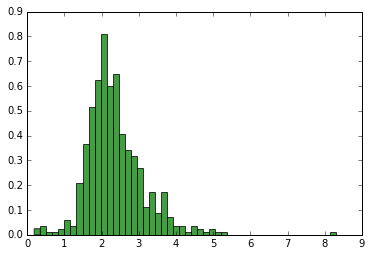

In [68]:
Disney = result.loc[lambda result: result.search == 'Disneyland']
n, bins, patches = plt.hist(Disney.tweetsperacre, 50, normed=1, facecolor='green', alpha=0.75)

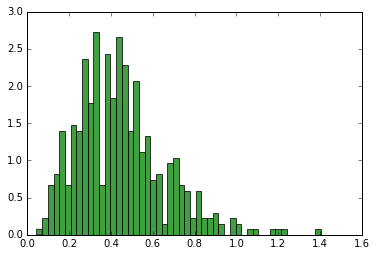

In [70]:
CA = result.loc[lambda result: result.search == 'California Adventure']
n, bins, patches = plt.hist(CA.tweetsperacre, 50, normed=1, facecolor='green', alpha=0.75)